# Introduction

In situations of forced displacement, the experiences of refugee children and those of children in host communities can differ in critical ways, impacting their education, health, and overall well-being. Understanding these differences is essential for designing better policies, programs, and interventions that leave no child behind.

This comparative analysis focuses on the children of **refugee** and **host communities** living in **South Sudan**, using the **UNHCR_FDS_SSD_2023 dataset** as the primary source of data. The Forced Displacement Survey (FDS) collects rich information about households and individuals, with particular attention to children under five, women who recently gave birth, and randomly selected members aged 15 and above. A total of **3,078 households** (2,086 refugee and 992 host) — with sampling carefully designed to ensure credible, representative results across both populations.

To produce statistically valid estimates, the analysis uses **adjusted sample weights** provided in the dataset. These weights account for differences in the probability of selection and correct for geographic distribution differences, aligning the sample with the broader population distribution described in the **Forced Displacement Survey South Sudan 2024 Full Report**. Specifically, the weights allow a 5% margin of error at a 95% confidence level for key indicators.

Throughout this work, particular care has been taken to ensure that comparisons between refugee and host community children are both fair and meaningful. Using weighted statistical techniques, we explored critical dimensions such as education access, school attendance patterns, health factors like vaccination and diarrhea treatment, and delays in educational progression.

This analysis was prepared by **Kevin Walter** and **Glorius Musyawa** for the **OECD-UNHCR Datathon**, with the shared goal of illuminating challenges and opportunities for improving the lives of displaced and host community children in South Sudan.


In [1]:
# Importing necessary libraries
import statsmodels
import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

## NOTE
Since the visualizations require extensive code, I’ve organized the plotting functions in a separate Python file—**south_sudan_visuals_function.py**. This approach keeps the main analysis clean and easy to follow, allowing the reader to focus on insights rather than code details.

In [2]:
# reading the dataset
df = pd.read_csv('/content/UNHCR_SSD_2023_FDS_data_caregiver.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Intro_07_1                2043 non-null   object 
 1   start                     2043 non-null   object 
 2   end                       2043 non-null   object 
 3   admin0                    2043 non-null   object 
 4   admin1                    1975 non-null   object 
 5   admin2                    1975 non-null   object 
 6   admin3                    1975 non-null   object 
 7   Final_01                  2043 non-null   object 
 8   ID                        2043 non-null   int64  
 9   rosterposition_caregiver  1992 non-null   float64
 10  rosterposition_child      2035 non-null   float64
 11  MV1                       2035 non-null   object 
 12  MV1a                      1547 non-null   object 
 13  MV2                       2008 non-null   object 
 14  MV3     

In [3]:
# doing away with the rows in wgh_str_u5 that have no weights or weights are zero
df = df[(df['wgh_str_u5'].isna() == False) | (df['wgh_str_u5'] > 0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2009 entries, 0 to 2042
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Intro_07_1                2009 non-null   object 
 1   start                     2009 non-null   object 
 2   end                       2009 non-null   object 
 3   admin0                    2009 non-null   object 
 4   admin1                    1942 non-null   object 
 5   admin2                    1942 non-null   object 
 6   admin3                    1942 non-null   object 
 7   Final_01                  2009 non-null   object 
 8   ID                        2009 non-null   int64  
 9   rosterposition_caregiver  1960 non-null   float64
 10  rosterposition_child      2001 non-null   float64
 11  MV1                       2001 non-null   object 
 12  MV1a                      1520 non-null   object 
 13  MV2                       1974 non-null   object 
 14  MV3          

In [4]:
df['Intro_07_1'].unique()

array(['Refugees', 'Host community North'], dtype=object)

In [5]:
# function that will help in getting stats and insights that
# represent the whole population(either refugee or host community)
def weighted_category_proportions2(df, var, weight,var_values,merge_dict = None):

  """df -- dataframe that has the column we are viewing
   var -- column we want to get the weighted rate
   weight -- column with the weight values
   var_values -- unique values in the var coumn we would like to get there rates"""

  df = df[df[var].isin(var_values)].copy()
  if merge_dict:
    df[var] = df[var].replace(merge_dict)
    var_values = list(merge_dict.values())

  def helper(df, var, weight,var_values):

    dummies = pd.get_dummies(df[var])

    # Ensure all expected columns exist, even if not in data
    for v in set(var_values):
        if v not in dummies.columns:
            dummies[v] = 0
    # Remove columns that are all zeros
    dummies = dummies.loc[:, (dummies != 0).any(axis=0)]

    dsw = DescrStatsW(dummies, weights=df[weight], ddof=0)

    means = pd.Series(dsw.mean, index=dummies.columns)

    result = {}
    for i, category in enumerate(dummies.columns):
        pct = means.get(category, 0) * 100
        result[f"{category.title()} -----> (%)"] = f"{pct:.1f}%"
    return result

      # Only valid answers

  groups = ['Host community North', 'Refugees']
  results = {}
  for group in groups:
    subset = df[df['Intro_07_1'] == group]
    stats = helper(df = subset, var = var,weight = weight,var_values = var_values)
    results[group] = stats

  return results


In [6]:
# Checking those who have the immunization cards(un_5 children)
var_values = ['yes', 'no', "don't know"]
results = weighted_category_proportions2(df, 'MV1', 'wgh_str_u5',var_values)

In [7]:
results

{'Host community North': {"Don'T Know -----> (%)": '0.5%',
  'No -----> (%)': '24.1%',
  'Yes -----> (%)': '75.4%'},
 'Refugees': {"Don'T Know -----> (%)": '0.1%',
  'No -----> (%)': '4.4%',
  'Yes -----> (%)': '95.5%'}}

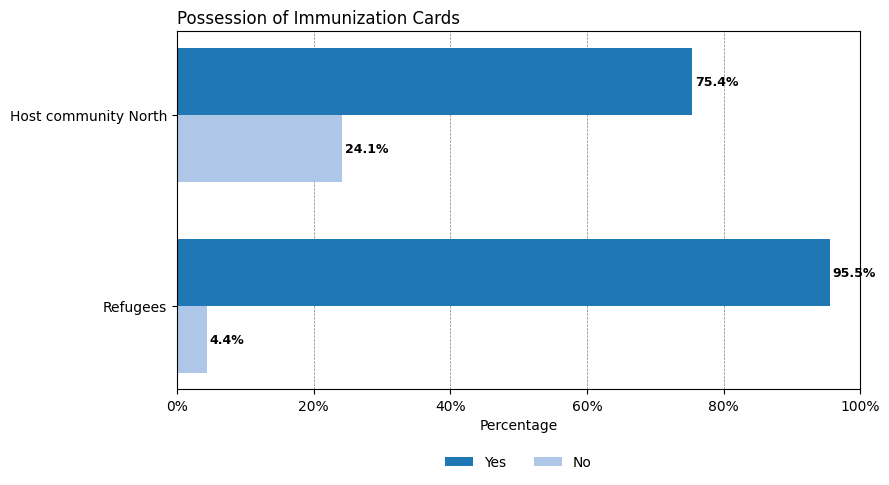

In [8]:
from south_sudan_visuals_function import possession_of_immunization_cards
possession_of_immunization_cards(results)

### Reported Ownership of Immunization Cards (Under-5 Children)

A higher proportion of caregivers among refugees in the North reported that their under-5 children had immunization cards compared to host community caregivers. Among refugees in the North, **95.5%** reported that their under-5 child had an immunization card, while **75.4%** of host community caregivers reported the same.  
Conversely, **24.1%** of host community caregivers stated that their under-5 child did not have an immunization card, compared to only **4.4%** among refugees in the North.



In [9]:
# Lets see the ones who showed the immmunization cards of the children.
# This can help us get a better measure of children with immunization cards
# if the rate will be close or the CI overlap with the response of immunization cards
# we can more confidently say the response on immunization cards more accurately displays
#children with immunization cards
df['MV1a'].unique()
show_imm_cards = ['no', 'yes']

In [10]:
results_card_show = weighted_category_proportions2(df, 'MV1a', 'wgh_str_u5',show_imm_cards)

In [11]:
results_card_show

{'Host community North': {'No -----> (%)': '28.0%', 'Yes -----> (%)': '72.0%'},
 'Refugees': {'No -----> (%)': '13.7%', 'Yes -----> (%)': '86.3%'}}

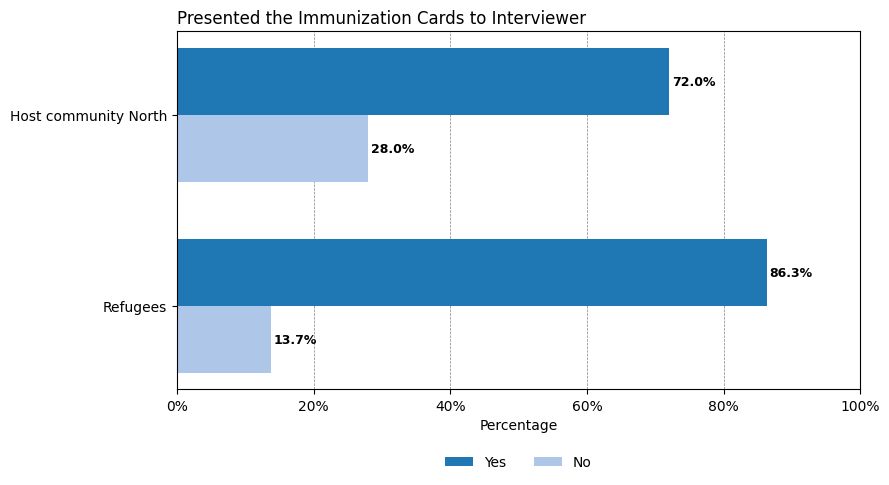

In [12]:
# those who have shown their immunization cards to the interviewer
from south_sudan_visuals_function import presented_immunization_cards
presented_immunization_cards(results_card_show)

### Presentation of Immunization Cards to Interviewers (Under-5 Children)

Among caregivers of under-5 children, **86.3%** of refugees in the North presented their child’s immunization card to the interviewers, compared to **72.0%** of host community caregivers.  
On the other hand, **28.0%** of host community caregivers did not present the card when requested, compared to **13.7%** among refugees in the North.

In [13]:
""" Now Onto the next want to know rate at which children from both population receive measles vaccination/measles coverage rate"""

print(df['MV2'].unique())
measles_vaccination = ['yes, with card', 'yes, without card', 'no', "don't know"]

['yes, with card' 'yes, without card' 'no' "don't know" nan]


In [14]:
merge_dict_measles = {
    'yes, with card': 'vaccinated',
    'yes, without card': 'vaccinated',
    'no': 'not vaccinated',
    "don't know": "don't know"
}

In [15]:
measles_vacc_coverage_rate1 = weighted_category_proportions2(df, 'MV2', 'wgh_str_u5',measles_vaccination,merge_dict_measles)

In [16]:
# measles coverage rate results
measles_vacc_coverage_rate1

{'Host community North': {"Don'T Know -----> (%)": '0.8%',
  'Not Vaccinated -----> (%)': '26.9%',
  'Vaccinated -----> (%)': '72.3%'},
 'Refugees': {"Don'T Know -----> (%)": '0.1%',
  'Not Vaccinated -----> (%)': '8.4%',
  'Vaccinated -----> (%)': '91.4%'}}

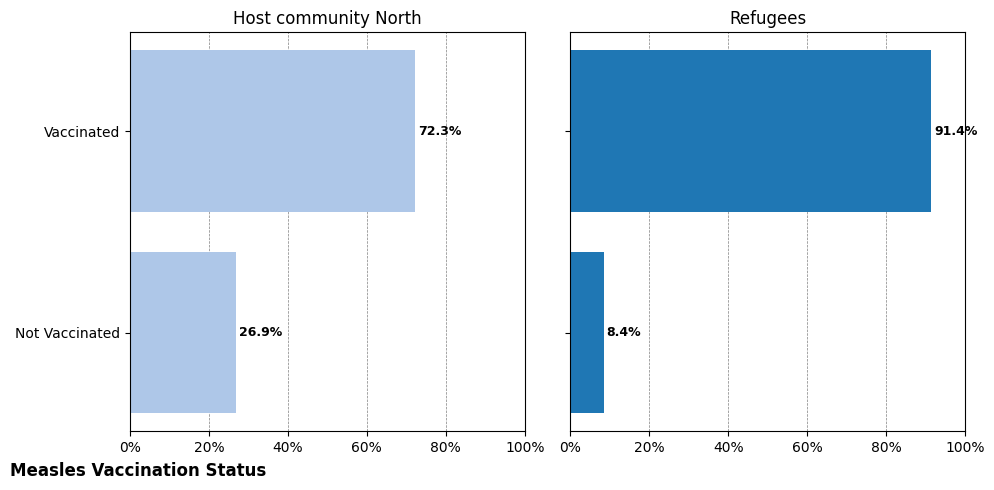

In [17]:
from south_sudan_visuals_function import measles_vaccination_status
measles_vaccination_status(measles_vacc_coverage_rate1)

### Measles Vaccination Status Among Under-5 Children: Host Community vs. Refugees in the North

Among refugees in the north, 91.4% of under-5 children were reported to have received a measles vaccination, compared to 72.3% among host community children.

Conversely, 26.9% of host community caregivers reported that their child had not received a measles vaccination, compared to only 8.4% among refugees in the north.

In [18]:
# Now let's check the children who have already received the full measles vaccination by this point
# A full vaccination is typically 2 doses

print(df['MV3'].unique())
full_measles_vaccination = [2.,1.,98.,0]
full_vacc_measles_dict = {2.:'full_vaccination',
                          1.:'incomplete vaccination',
                          98.:"unsure",
                          0.:'not yet vaccinated'}

[ 2.  1. nan 98.  0.]


In [19]:
full_vacc_measles_rate = weighted_category_proportions2(df, 'MV3', 'wgh_str_u5',full_measles_vaccination,full_vacc_measles_dict)

In [20]:
#Measles full vaccination
full_vacc_measles_rate

{'Host community North': {'Full_Vaccination -----> (%)': '43.8%',
  'Incomplete Vaccination -----> (%)': '49.8%',
  'Not Yet Vaccinated -----> (%)': '2.6%',
  'Unsure -----> (%)': '3.8%'},
 'Refugees': {'Full_Vaccination -----> (%)': '41.6%',
  'Incomplete Vaccination -----> (%)': '52.6%',
  'Not Yet Vaccinated -----> (%)': '1.4%',
  'Unsure -----> (%)': '4.5%'}}

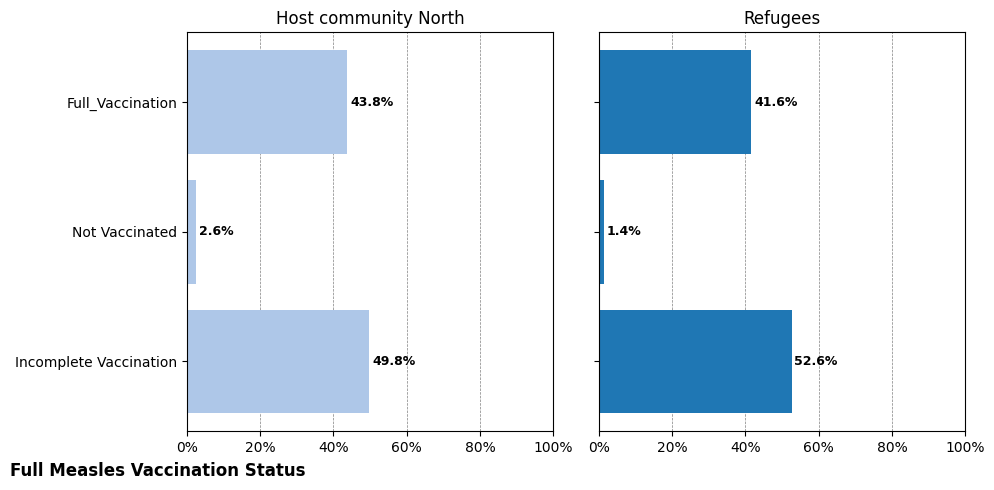

In [21]:
from south_sudan_visuals_function import full_measles_vaccination_status
full_measles_vaccination_status(full_vacc_measles_rate)

### Measles Full Vaccination Status (Two Doses) Among Under-5 Children

Among under-5 children, the proportion of fully vaccinated children (having received both doses of the measles vaccine) is similar between the host community (43.8%) and the refugee population (41.6%), with a small difference of 2.2 percentage points that is not statistically significant. In terms of incomplete vaccination, which refers to children having received only one dose, refugee children were slightly more likely to have received just one dose (52.6%) compared to their counterparts in the host community (49.8%). On the other hand, the proportion of children who have not yet received any measles vaccination is slightly higher in the host community (2.6%) compared to the refugee population (1.4%), indicating a small gap in vaccination coverage among the host community.

In [22]:
# main reasons for those whose children did not receive the last measles vaccination
print(df['MV6'].unique())
no_vacc_reasons = ['too far / transportation issue', 'other: specify',
       'no information about immunization schedules',
       'service is not available',
       'no time as i had to work / care for children',
       'service provider refused to provide me with service',
       'do not trust vaccine', "didn't know where to go",
       'staff were rude']

[nan 'too far / transportation issue' 'other: specify'
 'no information about immunization schedules' 'service is not available'
 'no time as i had to work / care for children'
 'service provider refused to provide me with service'
 'do not trust vaccine' "didn't know where to go" 'staff were rude']


In [23]:
df['MV6'].unique()

array([nan, 'too far / transportation issue', 'other: specify',
       'no information about immunization schedules',
       'service is not available',
       'no time as i had to work / care for children',
       'service provider refused to provide me with service',
       'do not trust vaccine', "didn't know where to go",
       'staff were rude'], dtype=object)

In [24]:
#This time the dataframe that we put in the function must be cleaned of and inconsistencies,where one reported
# in the MV2(ever received measles vaccine as don't know) and now some record (MV6)an issue for not receiving the vaccine
# the last time.This is inconsistent
measles_consistent_df = df[~((df['MV2'] == "don't know") & (df['MV6'].isin(no_vacc_reasons)))]


In [25]:
# Also to get the clear overeview I will also create a merge_dict  for this column
no_vacc_dict = {'too far / transportation issue':"transportation issue",
                'other: specify':'other reasons',
                'no information about immunization schedules': "no information about immunization schedules",
                'service is not available':"service unavailable",
                'no time as i had to work / care for children': "no time",
                'service provider refused to provide me with service':'issue with vaccine staff',
                'do not trust vaccine': "do not trust vaccine",
                "didn't know where to go":"no information about immunization schedules",
                'staff were rude':'issue with vaccine staff'}

In [26]:
results_no_vacc = weighted_category_proportions2(measles_consistent_df, 'MV6', 'wgh_str_u5',no_vacc_reasons,no_vacc_dict)

In [27]:
#Reasons why child did not receive vaccine in the last measles vaccination
results_no_vacc

{'Host community North': {'Do Not Trust Vaccine -----> (%)': '1.1%',
  'Issue With Vaccine Staff -----> (%)': '0.9%',
  'No Information About Immunization Schedules -----> (%)': '15.6%',
  'No Time -----> (%)': '5.0%',
  'Other Reasons -----> (%)': '35.1%',
  'Service Unavailable -----> (%)': '17.2%',
  'Transportation Issue -----> (%)': '25.1%'},
 'Refugees': {'Do Not Trust Vaccine -----> (%)': '0.3%',
  'Issue With Vaccine Staff -----> (%)': '1.1%',
  'No Information About Immunization Schedules -----> (%)': '15.0%',
  'No Time -----> (%)': '2.5%',
  'Other Reasons -----> (%)': '70.7%',
  'Service Unavailable -----> (%)': '8.6%',
  'Transportation Issue -----> (%)': '1.9%'}}

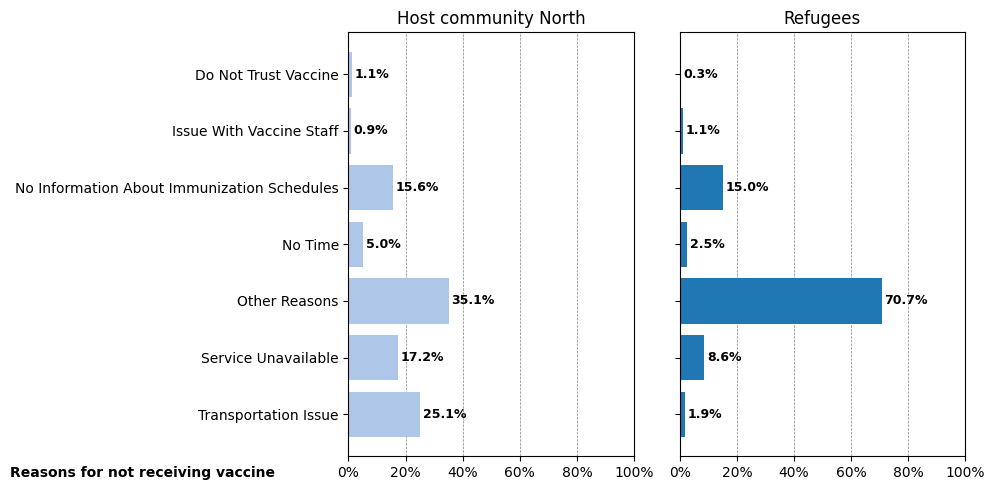

In [28]:
from south_sudan_visuals_function import reasons_for_not_receiving_vaccine
reasons_for_not_receiving_vaccine(results_no_vacc)

### Reasons for Missing Measles Vaccination Among Under-5 Children

In both the host community and refugee populations, various factors contribute to missed measles vaccinations. A higher proportion of refugees (70.7%) cited "other reasons" for missing the vaccination, compared to 35.1% in the host community, indicating a significant difference in the types of barriers experienced, though the exact nature of these reasons is unclear.

Among the host community, transportation issues (25.1%) and service unavailability (17.2%) were the most common barriers to vaccination. These were notably less prevalent among refugees, with only 1.9% citing transportation problems and 8.6% reporting service unavailability.

Both communities experienced similar levels of difficulty with lack of information about immunization schedules, with about 15% of caregivers in both groups reporting this issue. The proportion of caregivers reporting mistrust in vaccines or problems with vaccine staff was low in both groups, highlighting that these factors were not major contributors to missed vaccinations.

In [29]:
# Onto checking those who have received Pentavalent vaccine
print(df['MV7'].unique())
pentavalent_answer = ['yes, card', 'yes, no card', 'no',"don't know"]
pentavalent_dict ={'yes, card':'vaccinated',
                   'yes, no card':"vaccinated",
                   'no':"not vaccinated",
                   "don't know":"don't know"}

['yes, card' 'yes, no card' 'no' nan "don't know"]


In [30]:
#Checking pentavalent vaccine coverage rate
pentavalent_vacc_coverage_rate = weighted_category_proportions2(df, 'MV7', 'wgh_str_u5',pentavalent_answer,pentavalent_dict)

In [31]:
pentavalent_vacc_coverage_rate

{'Host community North': {"Don'T Know -----> (%)": '4.2%',
  'Not Vaccinated -----> (%)': '23.1%',
  'Vaccinated -----> (%)': '72.7%'},
 'Refugees': {"Don'T Know -----> (%)": '0.6%',
  'Not Vaccinated -----> (%)': '4.2%',
  'Vaccinated -----> (%)': '95.2%'}}

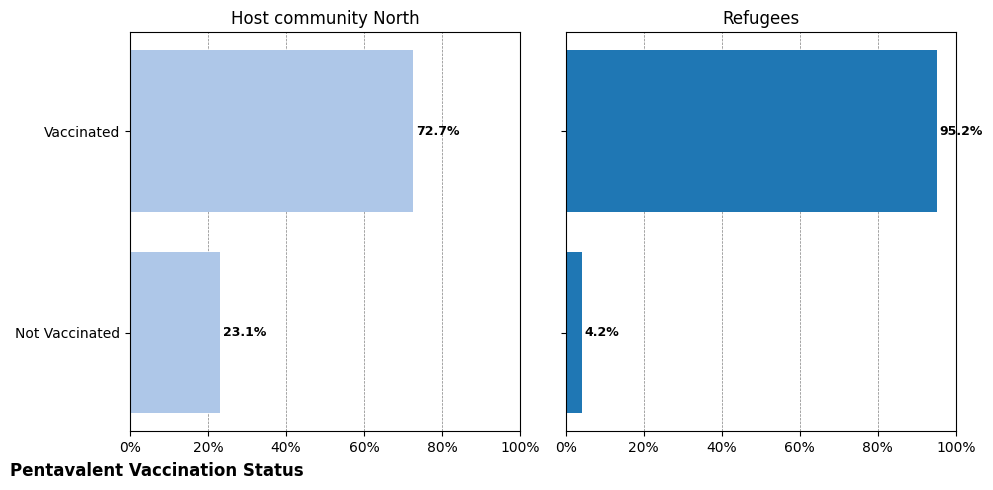

In [32]:
from south_sudan_visuals_function import pentavalent_vaccination_status
pentavalent_vaccination_status(pentavalent_vacc_coverage_rate)

# Pentavalent Vaccine Coverage Among Under-5 Children

The coverage of the pentavalent vaccine among under-5 children shows a significant difference between the host community and refugees. Among refugees, 95.2% of children received the pentavalent vaccine, compared to 72.7% in the host community. This highlights a considerably higher vaccination rate among refugee children. Conversely, 23.1% of children in the host community had not received the vaccine, while only 4.2% of refugee children were not vaccinated. These figures underscore the disparities in vaccine coverage between the two groups.

In [33]:
#Also to deal with inconsistencies that arise from a caregiver responding to(MV7) as received pentavalent vaccine but
#responds to (MV8) as zero for the response on how many times the child has received pentavalent vaccine.

pentavalent_clean_df = df[~((df['MV7'].isin(['yes, card', 'yes, no card'])) & (df['MV8'] == 0))]

In [34]:
# Pentavalent vaccine has usually been administered in 3 doses,but upon research I have learnt that there is a fourth dose
#that enhances the child immunity.after they have received the normal first three doses.
#https://www.unicef.org/myanmar/press-releases/immunization-programme-include-rotavirus-and-fourth-diphtheria-tetanus-vaccinations
"Starting from February 1, 2020, children aged one and a half years old who have already received the first three doses of five-in-one (DTP-HepB-Hib) will be given a fourth dose of five-in-one (DTP-HepB-Hib), in order to enhance the duration of immunity."

#https://pubmed.ncbi.nlm.nih.gov/17012882/
"The fourth dose was well tolerated in all age groups. Toddlers at 15, 16, 17 or 18 months of age are equally suitable recipients for booster immunization with the DTaP-IPV//PRP-T vaccine."
#This articles help show that the fourth booster dose can be administered and our data is okay
df['MV8'].unique()

array([ 4.,  3.,  2., nan,  1., 98.,  0.])

In [35]:
pent_vacc_times = [4.,3.,2.,1.,98.,0]
pentavalent_fullvacc_dict = {4.:'four doses',
                             3.:"three doses",
                             2.:'two doses',
                             1.:"one dose",
                             98.:"unsure",
                             0.:"no dose"}

In [36]:
pentavalent_vacc_rate = weighted_category_proportions2(pentavalent_clean_df, 'MV8', 'wgh_str_u5',pent_vacc_times,pentavalent_fullvacc_dict)

In [37]:
pentavalent_vacc_rate

{'Host community North': {'Four Doses -----> (%)': '15.5%',
  'One Dose -----> (%)': '24.1%',
  'Three Doses -----> (%)': '34.1%',
  'Two Doses -----> (%)': '23.2%',
  'Unsure -----> (%)': '3.1%'},
 'Refugees': {'Four Doses -----> (%)': '7.0%',
  'No Dose -----> (%)': '0.1%',
  'One Dose -----> (%)': '27.9%',
  'Three Doses -----> (%)': '46.6%',
  'Two Doses -----> (%)': '15.5%',
  'Unsure -----> (%)': '3.0%'}}

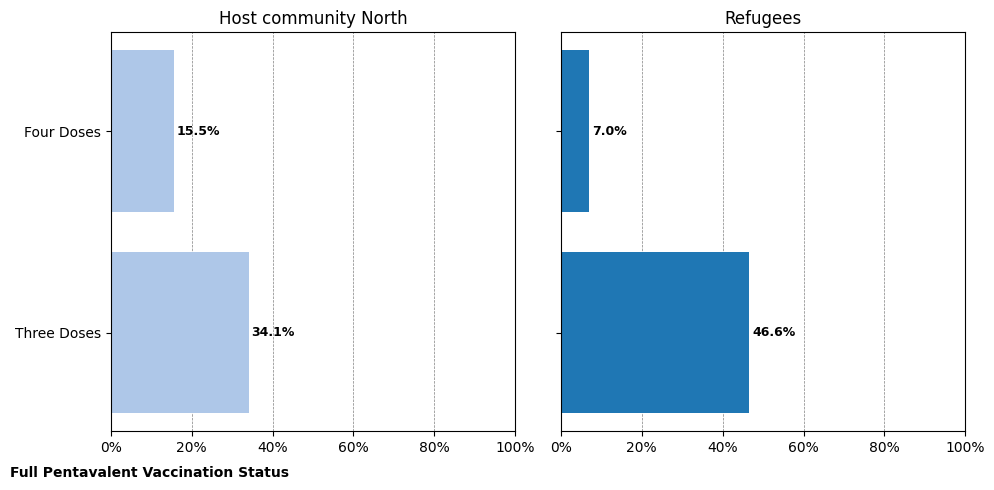

In [38]:
from south_sudan_visuals_function import full_pentavalent_vaccination_status
full_pentavalent_vaccination_status(pentavalent_vacc_rate)

## Pentavalent Vaccine Doses Received Among Under-5 Children

When analyzing the number of pentavalent vaccine doses received, there is a noticeable difference between the host community and refugees. Among refugees, 46.6% of children received three doses of the pentavalent vaccine, compared to 34.1% in the host community. This indicates a higher proportion of refugee children completing three doses. Conversely, a higher percentage of children in the host community (15.5%) received four doses, compared to just 7.0% among refugees. These differences suggest varying vaccination patterns and potential factors influencing dose completion across both groups.

In [39]:
#Onto vitamin A capsule rate
print(df['MV9'].unique())
vitamin_a_answer = ['yes, card', 'yes, no card', 'no',"don't know"]
vitamin_a_dict ={'yes, card':'supplemented',
                   'yes, no card':"supplemented",
                   'no':"not supplemented",
                   "don't know":"don't know"}
#Created a merge dictionary that will help merge and find vitamin A received rate
# To be clear vitamin A is not a vaccine it given along vaccines as supplementations and is highly recommended for children


['yes, card' "don't know" 'no' 'yes, no card' nan]


In [40]:
vitamin_a_coverage = weighted_category_proportions2(df, 'MV9', 'wgh_str_u5',vitamin_a_answer,vitamin_a_dict)

In [41]:
vitamin_a_coverage

{'Host community North': {"Don'T Know -----> (%)": '4.7%',
  'Not Supplemented -----> (%)': '39.5%',
  'Supplemented -----> (%)': '55.8%'},
 'Refugees': {"Don'T Know -----> (%)": '1.8%',
  'Not Supplemented -----> (%)': '11.0%',
  'Supplemented -----> (%)': '87.2%'}}

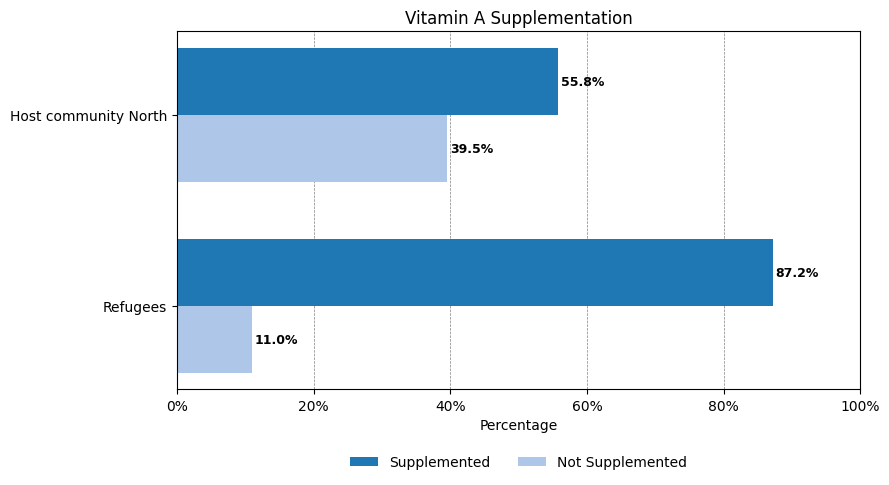

In [42]:
from south_sudan_visuals_function import vitamin_a_supplementation
vitamin_a_supplementation(vitamin_a_coverage)

### Vitamin A Supplementation Among Under-5 Children

A higher proportion of refugee children (87.2%) received Vitamin A supplementation in the past six months compared to children in the host community (55.8%). Meanwhile, 39.5% of host community children had not received Vitamin A supplementation, a much larger share than the 11.0% observed among refugees.

In [43]:
#Onto checking if child received any intestinal drug the past 6 months
print(df['MV10'].unique())
GI_drug_answer = ['yes',"don't know",'no']

['yes' "don't know" 'no' nan 'not applicable']


In [44]:
GI_coverage_rate = weighted_category_proportions2(df,'MV10','wgh_str_u5',GI_drug_answer)

In [45]:
GI_coverage_rate

{'Host community North': {"Don'T Know -----> (%)": '4.9%',
  'No -----> (%)': '55.7%',
  'Yes -----> (%)': '39.4%'},
 'Refugees': {"Don'T Know -----> (%)": '2.5%',
  'No -----> (%)': '24.8%',
  'Yes -----> (%)': '72.7%'}}

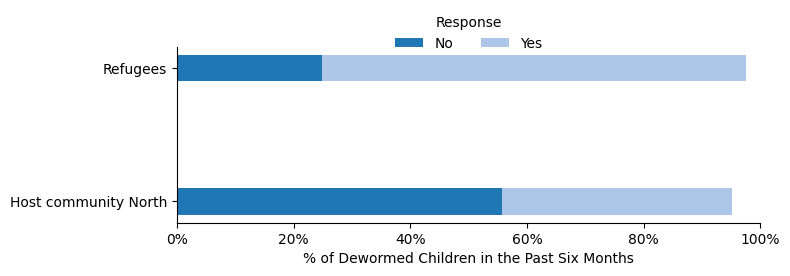

In [46]:
from south_sudan_visuals_function import dewormed_children_coverage
dewormed_children_coverage(GI_coverage_rate)

### Deworming Coverage Among Under-5 Children

A greater proportion of refugee children (72.7%) had received drugs for intestinal worms in the past six months compared to host community children (39.4%). Conversely, more than half of host community children (55.7%) had not received deworming treatment, compared to 24.8% among refugee children.

In [47]:
#if child has had diarrhea in the past two weeks
print(df['MV11'].unique())
diarrhea_answer = ['yes',"don't know",'no']

['yes' 'no' nan "don't know"]


In [48]:
health_issue_rate = weighted_category_proportions2(df,'MV11','wgh_str_u5',diarrhea_answer)

In [49]:
health_issue_rate

{'Host community North': {"Don'T Know -----> (%)": '0.5%',
  'No -----> (%)': '73.8%',
  'Yes -----> (%)': '25.6%'},
 'Refugees': {"Don'T Know -----> (%)": '0.2%',
  'No -----> (%)': '64.5%',
  'Yes -----> (%)': '35.3%'}}

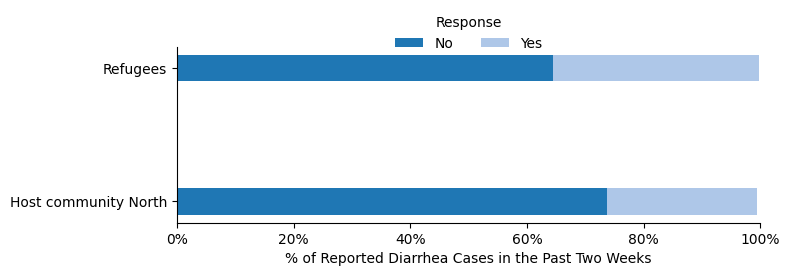

In [50]:
from south_sudan_visuals_function import reported_diarrhea_cases
reported_diarrhea_cases(health_issue_rate)

### Reported Diarrhea Cases Among Under-5 Children

In the two weeks preceding the survey, a higher proportion of refugee children (35.3%) experienced diarrhea compared to host community children (25.6%). Meanwhile, 73.8% of host community children were reported to have not had diarrhea, compared to 64.5% among refugee children.

In [51]:
df['MV12'].str.strip()

,MV12
0,NaN
1,NaN
2,NaN
3,NaN
4,B
...,...
2038,NaN
2039,NaN
2040,C
2041,B


In [52]:
#print(df['MV12'].unique())
treatment_given = ['B', 'A', 'BC', 'ABDC', 'D', 'C', 'ABCDEF',
       'ABCFED', 'BDC', 'ABCDE', 'OT', 'DK', 'BD', 'F',
       'BCE', 'ABCD', 'CB', 'E', 'ABCDFE', 'CE', 'BCDE',
       'BEC', 'DC', 'CD', 'AD', 'CBD', 'BCD', 'EDCBF', 'DB',
       'EDC', 'EFOT', 'BACDE', 'BCDEF', 'AB', 'EC']
treatment_dict = {
    'B': "Partial Recommended Treatment",
    'A': "No Treatment",
    'BC': "Recommended Treatment",
    'ABDC': "Mixed - includes recommended",
    'D': "Home Remedy",
    'C': "Partial Recommended Treatment",
    'ABCDEF': "Mixed - includes recommended",
    'ABCFED': "Mixed - includes recommended",
    'BDC': "Mixed - includes recommended",
    'ABCDE': "Mixed - includes recommended",
    'OT': "Unknown Treatment",
    'DK': "Home Remedy",
    'BD': "Partial Recommended Treatment",
    'F': "Medical Intervention Only",
    'BCE': "Recommended Treatment plus Medical Intervention",
    'ABCD': "Mixed - includes recommended",
    'CB': "Recommended Treatment",
    'E': "Medical Intervention Only",
    'ABCDFE': "Recommended,Medical,Home Remedy",
    'CE': "Partial Recommended Treatment plus Medical Intervention",
    'BCDE': "Recommended Treatment,Home Remedy and Medical Intervention",
    'BEC': "Recommended Treatment plus Medical Intervention",
    'DC': "Partial Recommended Treatment plus Medical Intervention",
    'CD': "Partial Recommended Treatment plus Medical Intervention",
    'AD': "Home Remedy",
    'CBD': "Mixed - includes recommended",
    'BCD': "Mixed - includes recommended",
    'EDCBF': "Recommended,Medical,Home Remedy",
    'DB': "Partial Recommended plus Home Remedy",
    'EDC': "Partial Recommended,Medical,Home Remedy",
    'EFOT': "Medical Intervention plus Other",
    'BACDE': "Recommended,Medical,Home Remedy",
    'BCDEF': "Recommended,Medical,Home Remedy",
    'AB': "Partial Recommended Treatment",
    'EC': "Partial Recommended Treatment plus Medical Intervention"
}
for i in treatment_given:
  if i not in treatment_dict.keys():
    print(i)

In [53]:
#Type of treatment child received for the health_diarrhea
diarrhea_treatment = weighted_category_proportions2(df,'MV12','wgh_str_u5',treatment_given,treatment_dict)

In [54]:
diarrhea_treatment

{'Host community North': {'Home Remedy -----> (%)': '14.2%',
  'No Treatment -----> (%)': '19.8%',
  'Partial Recommended Treatment -----> (%)': '63.7%',
  'Unknown Treatment -----> (%)': '2.4%'},
 'Refugees': {'Home Remedy -----> (%)': '15.5%',
  'Medical Intervention Only -----> (%)': '0.9%',
  'No Treatment -----> (%)': '13.4%',
  'Partial Recommended Treatment -----> (%)': '64.4%',
  'Unknown Treatment -----> (%)': '5.9%'}}

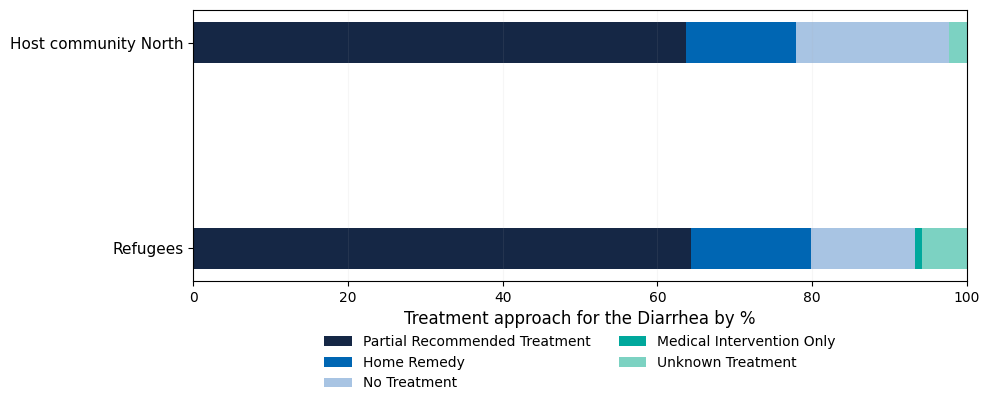

In [55]:
from south_sudan_visuals_function import treatment_approaches_for_diarrhea
treatment_approaches_for_diarrhea(diarrhea_treatment)

### Treatment Approaches for Under-5 Children with Diarrhea

Among under-5 children who experienced diarrhea, the most common response in both the host community and refugee populations was receiving partial recommended treatment. Specifically, 63.7% of host community children and 64.4% of refugee children received partial recommended care. Home remedies were used for 14.2% of host community cases and 15.5% of refugee cases. Notably, 19.8% of host community children received no treatment at all, compared to 13.4% among refugees. Additionally, 5.9% of refugee caregivers and 2.4% of host community caregivers reported unknown treatment methods. A small share (0.9%) of refugee children received only medical intervention without other forms of treatment, a pattern not observed among the host community.
